# In this notebook we explore the lazy constraint adding technique and whether it helps reliably speed up planning in the single-tunnel environment

Result: laziness is not helpful when life gets rough.

In [1]:
import sys
sys.path.append('../')
from panav.viz import draw_env
from panav.multi_path import explore_multi_path
from panav.env import NavigationEnv,box_2d_center,Box2DRegion

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

# Empty Environment

In [2]:

# 2D navigation environment

start_box_side = np.array([1,1])
goal_box_side = np.array([1,1])

top, bottom = 9,-9
start_x_offset = 7
goal_x_offset = 9
N = 3

start_locs = np.vstack([
np.vstack([np.ones(N)*start_x_offset,np.linspace(top,bottom, N)]).T,
np.vstack([np.ones(N)*(-start_x_offset),np.linspace(top,bottom, N)]).T])

goal_locs = np.vstack([
np.vstack([np.ones(N)*(-goal_x_offset),np.linspace(bottom,top, N)]).T,
np.vstack([np.ones(N)*goal_x_offset,np.linspace(bottom,top, N)]).T])


starts = [box_2d_center(s,start_box_side) for s in start_locs]
goals = [box_2d_center(g,goal_box_side) for g in goal_locs]

start = np.array(list(starts[0].centroid().coords)[0])
goal = np.array(list(goals[0].centroid().coords)[0])

limits = [(-10.0,10.0),(-10.0,10.0)]

# Construct the hybrid graph representation of the environment
bloating_r = 0.5 
env = NavigationEnv(limits,[],starts,goals)

# Single Tunnel

In [3]:

O1 = Box2DRegion((-2.5,2.5),(0.5,10))
O2 = Box2DRegion((-2.5,2.5),(-10,-1.0))
env = NavigationEnv(limits,[O1,O2],starts,goals)

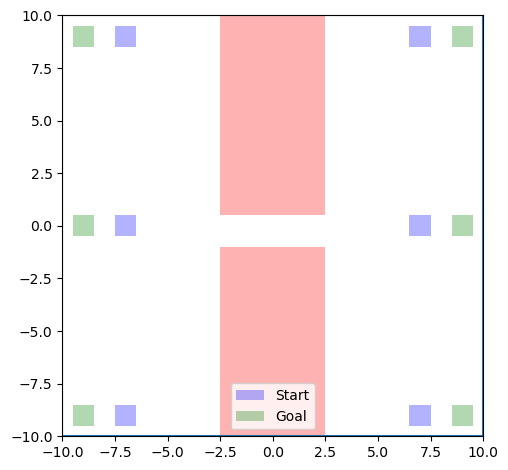

In [4]:
ax = plt.gca()
draw_env(env,[], ax)
plt.tight_layout()
plt.show()    


In [6]:
from panav.PBS.conflict import plan_obs_conflict
def lazy_optim(planner, env, start, goal, obstacle_trajectories):
    active = []
    m = len(obstacle_trajectories)

    i = 0
    while True:
        print("num obstacle trajectories:{}/{}".format(i,m))
        p = planner(env,start,goal,active)
        if p is None:
            print('Problem becomes infeasible.')
            break
        conflicted_obs = plan_obs_conflict(p, obstacle_trajectories, bloating_r)
        if not conflicted_obs:
            return p
        active.append(conflicted_obs)
        
        i+=1
        if i>m:
            break

    return None

from panav.SAMP import Tube_Planning
from panav.util import unique_tx
from time import time
from functools import partial
agents = set(np.arange(len(env.starts)))

vmax = 1.0
d = 2

plan = []
times = []
success = True
fail_time = None
for agent in agents:
    print(agent)

    t0 = time()
    
    start = env.starts[agent]
    goal = env.goals[agent]

    agent_success = False
    
    
    for K in range(1,8):
        print("K",K)
        planner = lambda env, start, goal, obs_trajectories: Tube_Planning(env,start, goal, vmax , bloating_r, 
                                                           obs_trajectories=obs_trajectories, 
                                                           d=d, K=K,
                                                           ignore_finished_agents = False)

        results = lazy_optim(planner, env, start, goal, plan)
        if results is not None:
            t,xs = results
            times.append(time()-t0)
            print(times[-1])
            t,xs = unique_tx(t,xs)
            plan.append((t,xs))
            agent_success = True
            break
        

    if not agent_success:
        print("Solution failed.")
        success = False
        times.append(time()-t0)
        break



0
K 1
num obstacle trajectories:0/0
Problem becomes infeasible.
K 2
num obstacle trajectories:0/0
Problem becomes infeasible.
K 3
num obstacle trajectories:0/0
0.07466697692871094
1
K 1
num obstacle trajectories:0/1
0.008549928665161133
2
K 1
num obstacle trajectories:0/2
Problem becomes infeasible.
K 2
num obstacle trajectories:0/2
Problem becomes infeasible.
K 3
num obstacle trajectories:0/2
num obstacle trajectories:1/2
Problem becomes infeasible.
K 4
num obstacle trajectories:0/2
num obstacle trajectories:1/2
0.10274720191955566
3
K 1
num obstacle trajectories:0/3
Problem becomes infeasible.
K 2
num obstacle trajectories:0/3
Problem becomes infeasible.
K 3
num obstacle trajectories:0/3
num obstacle trajectories:1/3
num obstacle trajectories:2/3
0.09419703483581543
4
K 1
num obstacle trajectories:0/4
num obstacle trajectories:1/4
Problem becomes infeasible.
K 2
num obstacle trajectories:0/4
num obstacle trajectories:1/4
num obstacle trajectories:2/4
Problem becomes infeasible.
K 3
n

/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/PBS/conflict.py:70: RuntimeWarning: divide by zero encountered in divide
  va = (pa[:,1]-pa[:,0])/(ta[1]-ta[0])
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/PBS/conflict.py:70: RuntimeWarning: invalid value encountered in divide
  va = (pa[:,1]-pa[:,0])/(ta[1]-ta[0])
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/PBS/conflict.py:74: RuntimeWarning: invalid value encountered in multiply
  u = pa[:,0]-pb[:,0] - (va*ta[0]-vb*tb[0])
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/PBS/conflict.py:81: RuntimeWarning: invalid value encounter

num obstacle trajectories:3/4
num obstacle trajectories:4/4
K 4
num obstacle trajectories:0/4
num obstacle trajectories:1/4
num obstacle trajectories:2/4
num obstacle trajectories:3/4
num obstacle trajectories:4/4
K 5
num obstacle trajectories:0/4
num obstacle trajectories:1/4
num obstacle trajectories:2/4
num obstacle trajectories:3/4
num obstacle trajectories:4/4
K 6
num obstacle trajectories:0/4
num obstacle trajectories:1/4
num obstacle trajectories:2/4
num obstacle trajectories:3/4
11.371746063232422
5
K 1
num obstacle trajectories:0/5
Problem becomes infeasible.
K 2
num obstacle trajectories:0/5
Problem becomes infeasible.
K 3
num obstacle trajectories:0/5
num obstacle trajectories:1/5
num obstacle trajectories:2/5
num obstacle trajectories:3/5
Problem becomes infeasible.
K 4
num obstacle trajectories:0/5
num obstacle trajectories:1/5
num obstacle trajectories:2/5
num obstacle trajectories:3/5
num obstacle trajectories:4/5
Problem becomes infeasible.
K 5
num obstacle trajectories

/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/PBS/conflict.py:81: RuntimeWarning: invalid value encountered in add
  return np.linalg.norm(u + lb * v)<= ra+rb \
/Users/tianpengzhang/Dropbox (Harvard University)/Tianpeng's research/Tianpeng & Lina/Multiagent Motion Planning/PA-Nav/notebooks_playground/../panav/PBS/conflict.py:82: RuntimeWarning: invalid value encountered in add
  or np.linalg.norm(u + ub * v)<= ra+rb


num obstacle trajectories:2/5
num obstacle trajectories:3/5
num obstacle trajectories:4/5
num obstacle trajectories:5/5
Solution failed.


# The conclusion is that, we cannot run away with laziness when planning situation gets tough (particularly, in the single tunnel case). We must honestly include all the agents when dealing with single tunnel passing!